## 10.0 Stratified Dataset
> - The training dataset is highly unbalance where default class makes up around 8% of the total.  To combat this unbalance I decided to use [under-sampling](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) so that the target class (0-non-defaults and 1-defaults) can be represented more equally.
> - I decided to use under-sampling versus over-sampling because I have a large dataset.
> - To perform the under-sampling I use sklearn's [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html). 
> - The `AMT_ANNUITY` field was used to create a category field that served as the stratifying class.

In [13]:
#import helper ultility module
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

## 10.1 Import Combined Dataset
> - The combined dataset contains all the pre-processed datasets.
> - In order to stratified I created a category field from the `AMT_ANNUITY` field to serve as the percentage sampling class.
I chose the `AMT_ANNUITY` field because its normaly distributed.

In [15]:
dataset = utils.get_combined_dataset()

In [16]:
dataset.head()

,SK_ID_CURR,TARGET,DATASET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_STD,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_STD,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_STD
0,100002,1.00,train,12.22,12.92,10.11,0.02,"-9,461.00",-637.00,114.13,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,100003,0.00,train,12.51,14.07,10.48,0.00,"-16,765.00","-1,188.00",64.68,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0.00,train,11.12,11.81,8.82,0.01,"-19,046.00",-225.00,123.37,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0.00,train,11.81,12.65,10.30,0.01,"-19,005.00","-3,039.00",187.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,100007,0.00,train,11.71,13.15,9.99,0.03,"-19,932.00","-3,038.00",124.11,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344971 entries, 0 to 344970
Columns: 236 entries, SK_ID_CURR to CC_SK_DPD_DEF_STD
dtypes: float64(212), int64(15), object(9)
memory usage: 621.1+ MB


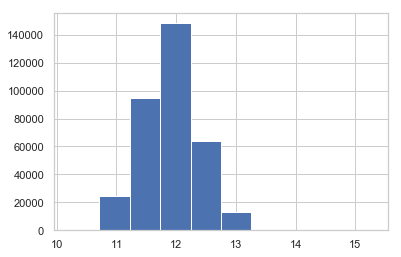

In [18]:
#create stratifying field
strat_field = 'AMT_INCOME_TOTAL'

#show its distribution
dataset[strat_field].hist()
plt.show()

In [19]:

strat_column = strat_field + "_GROUP"

dataset[strat_column] = dataset[strat_field].apply(lambda x:int(  round(x)))
dataset[strat_column] = dataset[strat_column].apply(lambda x: 14 if x==15 else x)
dataset[strat_column].value_counts().sort_index()

10        84
11     65672
12    239591
13     39518
14       106
Name: AMT_INCOME_TOTAL_GROUP, dtype: int64

In [20]:
#lets filter only by training subset
train_df = dataset[dataset['DATASET']=='train']

#lets filter only by test subset
test_df = dataset[dataset['DATASET']=='test']

In [21]:
#def fun summarize the percentages of 1 and 0 target values.
def target_percent(df):
    percent_df =  df.groupby('TARGET').size().to_frame()
    percent_df.columns = ['Count'] 
    percent_df['Percent'] = percent_df['Count'].apply(lambda x : round(100*float(x) / len(df), 2))
    return percent_df

In [22]:
target_percent(train_df)

,Count,Percent
TARGET,,
0.00,271937,91.80
1.00,24290,8.20


## 10.2 Stratified Dataset

In [23]:
def stratified_dataset(df,test_size):
    """ Perform stratification and return test index"""
    
    # split between target value 1 and 0
    non_defaults = df[df['TARGET']==0].copy().reset_index(drop=True)
    defaults = df[df['TARGET']==1].copy().reset_index(drop=True)
    
    X = non_defaults.drop([strat_column], axis=1).values
    y = non_defaults[strat_column].values
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=54)
    splits = list(sss.split(X, y))
    
    new_df = non_defaults.iloc[splits[0][1]].copy()
    new_df = new_df.append(defaults).reset_index(drop=True)
    
    return new_df

In [24]:
#create new stratified dataset 
stratified_df =  stratified_dataset(train_df,0.09)

In [25]:
target_percent(stratified_df)

,Count,Percent
TARGET,,
0.00,24475,50.19
1.00,24290,49.81


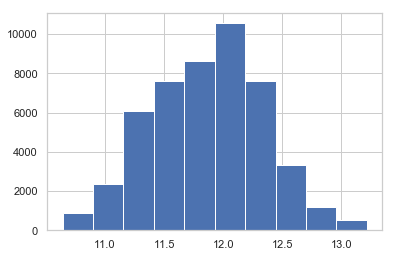

In [26]:
stratified_df[strat_field].hist()
plt.show()

### 10.3 Save Stratified Training and Testing Datasets
> - Here we save the stratified training and testing datasets to file 
> - These two datasets have not been normalized or one-hot-encoded.
> - To save stratified training datase we exclude the `DATASET` field before saving.
> - To save test datase we exclude the `TARGET` and `DATASET` fields before saving.

In [27]:
stratified_df.drop(['DATASET',strat_column],axis=1).to_csv('data_stratified/train.csv',index=False)
print("Stratified training dataset saved with row count of {}.".format(len(stratified_df)))

Stratified training dataset saved with row count of 48765.


In [28]:
test_df.drop(['DATASET','TARGET',strat_column],axis=1).to_csv('data_stratified/test.csv',index=False)
print("Testing dataset saved with row count of {}.".format(len(test_df)))

Testing dataset saved with row count of 48744.


### 10.4 Save Normalized Training and Testing Datasets
> - Here we save normalized or one-hot-encoded stratified training and testing datasets to file.

> #### Normalize Steps:
> - First we normalized the float features.
> - Then we one-hot-encode all the integer and string features. 
> - For convenience and simplicity before one-hot-encoding the string features we convert all string features into integers value.  We convert each value in a string feature by assigning an integer to each unique string value.
> - We use helper class called `NormData` to normalized the datasets.

> #### Saving Steps:
> - To save stratified training datase we exclude the `DATASET` fields before saving.
> - To save test datase we exclude the `TARGET` and `DATASET` fields before saving.

In [29]:
 stratified_df.head()

,SK_ID_CURR,TARGET,DATASET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_CNT_INSTALMENT_MATURE_CUM_STD,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_STD,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_STD,AMT_INCOME_TOTAL_GROUP
0,121145,0.00,train,11.36,12.57,9.79,0.01,"-22,859.00",0.00,217.28,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11
1,446181,0.00,train,11.41,12.87,10.35,0.02,"-13,217.00","-1,172.00",65.53,...,2.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11
2,378637,0.00,train,11.63,12.97,10.44,0.03,"-21,215.00",-808.00,180.97,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12
3,402605,0.00,train,11.81,13.42,10.27,0.02,"-22,186.00",0.00,210.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12
4,156160,0.00,train,11.12,12.10,9.11,0.01,"-9,434.00","-2,038.00",91.36,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11


In [30]:
#let combined the stratified training and testing to then pass to the normalizing object
new_dataset = stratified_df.append(test_df, ignore_index=True).reset_index(drop=True)

In [31]:
norm_data = utils.NormData(new_dataset.drop([strat_column],axis=1),StandardScaler())

>> Normalized float features.
>> Column count before one hot encoding: 236.
>> One-hot-encoded integer features.
>> One-hot-encoded string features.
>> Column count after one hot encoding: 284.
>> Total columns added: 48.


In [32]:
#get train dataframe already filtered
train_df_norm  = norm_data.data_train_clean

#save train dataset to file
train_df_norm.to_csv('data_stratified/train_norm.csv',index=False)

msg = "Normalized stratified training dataset saved with row count of {} and column count of {}."
print(msg.format(len(train_df_norm),len(train_df_norm.columns)))

Normalized stratified training dataset saved with row count of 48765 and column count of 283.


In [33]:
#get test dataframe already filtered
test_df_norm  = norm_data.data_test_clean

#save test dataset to file
test_df_norm.to_csv('data_stratified/test_norm.csv',index=False)

msg = "Normalized test dataset saved with row count of {} and column count of {}."
print(msg.format(len(test_df_norm),len(test_df_norm.columns)))

Normalized test dataset saved with row count of 48744 and column count of 282.
